# Banana Center Line Fitting
This notebook shows how the center line fitting is done using some more graphics.

In C++ this is implemented using the [ceres solver](http://ceres-solver.org/) library. One of the main differences is that the ceres solver operates on one cost function per data point (i.e. per point on the contour) while the solvers used here operate on arrays of data, i.e. there's a single constraint for the whole set of points on the contour.

In [1]:
import yaml

import numpy as np
from scipy.optimize import least_squares, minimize

import matplotlib.pyplot as plt

## Load Contour
Rather than also running OpenCV to extract the contours of a banana here we just load the previously saved reference contour to focus on the line fitting.

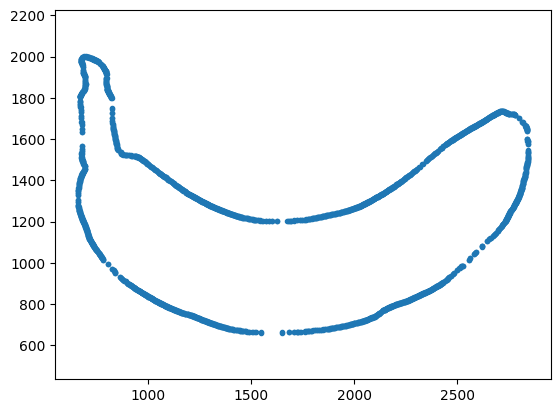

In [2]:
def load_contour(path: str, contour_name: str):
    with open(path) as f:
        _ = f.readlines(2) # skip the first two lines of the file containing an opencv specific header
        yml = yaml.safe_load(f)
        return np.asarray(yml[contour_name])

contour = load_contour('../resources/reference-contours.yml', 'banana')
contour = contour.reshape(len(contour)//2, 2) # opencv stores contours as 1D arrays with alternating x & y values
contour = contour.T # flip so that we have two arrays, one with x & one with y (easier to work with in the next steps)

# for further plotting
def plot_with_coeffs(contour, coeffs=None):
    plt.plot(*contour, '.')
    if coeffs is not None:
        plt.title(r'$y \approx %.4f + %.4f \cdot x + %.4f \cdot x^2$' %(coeffs[0], coeffs[1], coeffs[2]))
        min_x = np.min(contour[0])
        max_x = np.max(contour[0])
        x = np.linspace(min_x-100, max_x+100, max_x-min_x+201)
        y = coeffs[0] + coeffs[1] * x + coeffs[2] * x**2
        plt.plot(x,y)
    plt.axis('equal')
    plt.show()

# visualise contour only
plot_with_coeffs(contour)

## Fit using [`numpy` `Polynomial.fit`](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html)

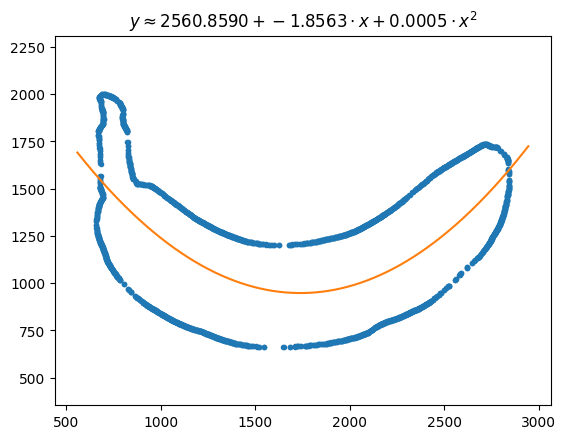

In [3]:
poly = np.polynomial.Polynomial.fit(*contour, 2)
poly = poly.convert() # convert to normal domain

plot_with_coeffs(contour, poly.coef)

## Fit using [`scipy` `least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-3.049e+02 -3.041e+02 ... -2.885e+02 -2.896e+02]
           x: [ 2.561e+03 -1.856e+00  5.339e-04]
        cost: 132889160.53930564
         jac: [[-1.000e+00 -1.547e+03 -2.393e+06]
               [-1.000e+00 -1.546e+03 -2.390e+06]
               ...
               [-1.000e+00 -1.650e+03 -2.722e+06]
               [-1.000e+00 -1.649e+03 -2.719e+06]]
        grad: [-2.359e-06  3.593e-02 -5.712e+00]
  optimality: 5.711569786071777
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 13
        njev: 12


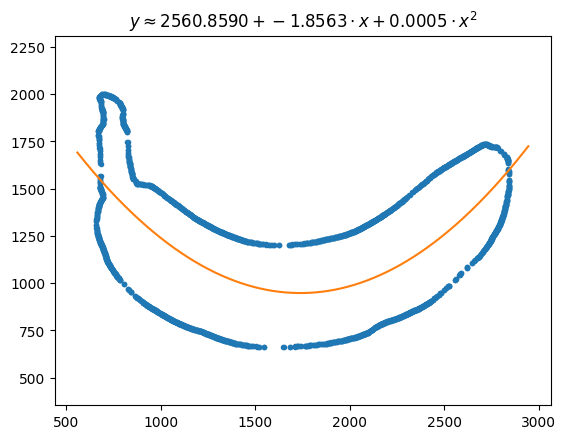

In [4]:
def objfun(coef, contour):
    x = contour[0]
    y_estimate = coef[0] + coef[1] * x + coef[2] * x**2
    return contour[1] - y_estimate

x0 = np.array([1,1,1])

res = least_squares(objfun, x0, args=(contour,))
print(res)

plot_with_coeffs(contour, res.x)

## Fit using [`scipy` `minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 265778576.56163365
        x: [ 2.559e+03 -1.854e+00  5.332e-04]
      nit: 8
      jac: [-3.780e+02 -3.048e+05 -6.861e+07]
 hess_inv: [[ 7.165e-03 -9.429e-06  2.617e-09]
            [-9.429e-06  1.326e-08 -3.805e-12]
            [ 2.617e-09 -3.805e-12  1.119e-15]]
     nfev: 244
     njev: 58


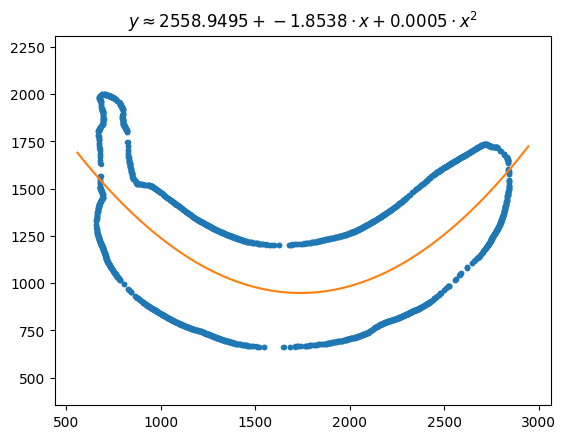

In [5]:
def objfun(coef, contour):
    x = contour[0]
    y_estimate = coef[0] + coef[1] * x + coef[2] * x**2
    return np.sum(np.square(contour[1] - y_estimate))

x0 = np.array([1,1,1])

res = minimize(objfun, x0, args=(contour,))
print(res)

plot_with_coeffs(contour, res.x)